# Packages

In [115]:
# ==========================================
# Chargement
# ==========================================
import os
import pickle
import joblib
import numpy as np
import pandas as pd

from __future__ import annotations
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chargement des résultats

In [116]:
# ---------- Helpers ----------
def load_any(path):
    """Charge un objet avec joblib puis pickle si besoin."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def try_read_meta(path):
    """Lit un CSV méta (Series si 1 colonne, sinon DataFrame)."""
    try:
        meta = pd.read_csv(path, index_col=0)
        if meta.shape[1] == 1:
            meta = meta.iloc[:, 0]  # Series
        return meta
    except Exception as e:
        print(f"⚠️ Impossible de lire {path} : {e}")
        return None

def safe_meta_print(meta, keys):
    """Affiche les clés demandées sans lever d'erreur si elles manquent."""
    if meta is None:
        print("⚠️ Pas de méta disponible.")
        return
    # Convertit en dict pour accès uniforme
    if isinstance(meta, pd.Series):
        d = meta.to_dict()
    elif isinstance(meta, pd.DataFrame):
        # prend la 1ère ligne si DataFrame
        d = meta.iloc[0].to_dict()
    elif isinstance(meta, dict):
        d = meta
    else:
        print(f"(info) Type de méta inattendu: {type(meta)}")
        d = {}

    print("\n--- Métadonnées AR(1) (clé: valeur) ---")
    for k in keys:
        v = d.get(k, None)
        print(f"{k}: {v}")

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

def ensure_ms_index_df(df: pd.DataFrame) -> pd.DataFrame:
    """Retourne un DataFrame trié avec un DatetimeIndex en début de mois (freq=MS)."""
    out = df.copy()
    out.index = pd.to_datetime(out.index).to_period("M").to_timestamp(how="start")
    return out.sort_index().asfreq("MS")

def ensure_features_present(df: pd.DataFrame, features: list[str], target_col: str | None = None):
    missing = [c for c in (features or []) if c not in df.columns]
    if target_col is not None and target_col not in df.columns:
        missing.append(target_col)
    if missing:
        raise ValueError(f"Colonnes manquantes dans le DataFrame: {missing}")

def make_exp_from_loaded(
    *,
    models,                 # liste de modèles déjà entraînés (un par fenêtre)
    features,               # list[str]
    train_periods,          # list[datetime-like], même longueur que models
    preprocs=None,          # list[...] ou None
    step_months: int = 12,
) -> dict:
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("'models' doit être une liste non vide.")
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("'features' doit être une liste non vide.")
    if not isinstance(train_periods, (list, tuple)) or len(train_periods) != len(models):
        raise ValueError("'train_periods' doit avoir la même longueur que 'models'.")
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("'preprocs' doit avoir la même longueur que 'models' si fourni.")

    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   int(step_months),
    }

def exp_from_linreg_bundle_no_refit(linreg_bundle: dict) -> dict:
    """
    Construit l'exp_results attendu par permutation_importance_pseudo_oos
    en réutilisant UNIQUEMENT ce qui est déjà sauvegardé dans le bundle.
    AUCUN ré-entraînement.
    """
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide (pas un dict).")

    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans le bundle (params.features).")

    # Modèles par fenêtre (doivent avoir été sauvegardés dans le bundle)
    models = linreg_bundle.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise RuntimeError(
            "Ce bundle ne contient pas la liste des modèles par fenêtre ('models'). "
            "Sans ces objets, l'importance par permutation ne peut pas être calculée "
            "sans ré-entraîner. Sauvegarde les modèles lors de l'apprentissage, puis recharge."
        )

    # Préproc par fenêtre (optionnel)
    preprocs = linreg_bundle.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' n'a pas la même longueur que 'models'.")

    # Périodes d'entraînement par fenêtre (alignement temporel)
    train_periods = linreg_bundle.get("train_fit_dates", None)
    if train_periods is None or len(train_periods) != len(models):
        raise RuntimeError("'train_fit_dates' manquant ou de longueur différente de 'models'.")

    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   12,
    }

In [117]:
# ---------- Fichiers ----------
AR1_LAST_PKL  = "AR1_last_trained_model.pkl"
AR1_LAST_META = "AR1_last_trained_model_meta.csv"
AR1_BUNDLE    = "AR1_h12_oos_bundle.pkl"

LINREG_PKL    = "linear_regression.pkl"
LINREG_META   = "linear_regression_meta.csv"

# 🔹 AR(p)
ARP_LAST_PKL  = "ARP_last_trained_model.pkl"
ARP_LAST_META = "ARP_last_trained_model_meta.csv"
ARP_BUNDLE    = "ARP_h12_oos_bundle.pkl"

In [118]:
# ============= CHARGEMENTS COMPLETS =============

print("=== Chargement AR(1) ===")
try:
    ar1_model = load_any(AR1_LAST_PKL)
    print("✅ Modèle AR(1) chargé.")
except Exception as e:
    ar1_model = None
    print(f"⚠️ Modèle AR(1) non chargé : {e}")
ar1_meta  = try_read_meta(AR1_LAST_META)

try:
    ar1_bundle = load_any(AR1_BUNDLE)
    print("✅ Bundle AR(1) chargé (OOS h=12).")
except Exception as e:
    ar1_bundle = None
    print(f"⚠️ Bundle AR(1) non chargé : {e}")

print("\n=== Chargement AR(p) ===")
try:
    arp_model = load_any(ARP_LAST_PKL)
    print("✅ Modèle AR(p) chargé.")
except Exception as e:
    arp_model = None
    print(f"⚠️ Modèle AR(p) non chargé : {e}")
arp_meta = try_read_meta(ARP_LAST_META)

try:
    arp_bundle = load_any(ARP_BUNDLE)
    print("✅ Bundle AR(p) chargé (OOS h=12).")
except Exception as e:
    arp_bundle = None
    print(f"⚠️ Bundle AR(p) non chargé : {e}")

print("\n=== Chargement Régression Linéaire ===")
try:
    linreg_bundle = load_any(LINREG_PKL)   # dict avec 'oos_predictions', 'params', etc.
    print("✅ Régression linéaire chargée.")
except Exception as e:
    linreg_bundle = None
    print(f"⚠️ Régression linéaire non chargée : {e}")
linreg_meta = try_read_meta(LINREG_META)

=== Chargement AR(1) ===
✅ Modèle AR(1) chargé.
✅ Bundle AR(1) chargé (OOS h=12).

=== Chargement AR(p) ===
✅ Modèle AR(p) chargé.
✅ Bundle AR(p) chargé (OOS h=12).

=== Chargement Régression Linéaire ===
✅ Régression linéaire chargée.


# Changement de df

In [119]:
# =============== STANDARDISATION ===============
def standardize_oos_predictions(
    oos: pd.DataFrame,
    *,
    method_name: str | None = None,
    date_candidates=("date","dates"),
    true_candidates=("y_true","true","target","y"),
    pred_candidates=("y_pred","pred","prediction","forecast","yhat"),
) -> pd.DataFrame:
    """
    Convertit un DataFrame OOS quelconque en colonnes standardisées: (date, true, pred[, method]).
    - Ne dépend d'aucun modèle particulier.
    - Suppose que oos contient au moins une des colonnes candidates pour date/true/pred.
    """
    d = oos.copy()
    if d.index.name is not None:
        d = d.reset_index()

    cols = {c.lower(): c for c in d.columns}
    def _pick(cands):
        for k in cands:
            if k in cols:
                return cols[k]
        return None

    date_col = _pick(date_candidates)
    true_col = _pick(true_candidates)
    pred_col = _pick(pred_candidates)
    if not (date_col and true_col and pred_col):
        raise ValueError(f"Colonnes manquantes (date/true/pred) dans {d.columns.tolist()}")

    out = d[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
    out["date"] = _normalize_month_start(out["date"])
    if method_name:
        out["method"] = method_name
    return out.reset_index(drop=True)

In [120]:
def build_df_from_bundle(bundle: dict, default_method: str = "Model") -> pd.DataFrame:
    """
    Extrait/standardise 'oos_predictions' depuis un bundle générique.
    - Bundle attendu: {'oos_predictions': DataFrame, 'params': {'model': ...}, ...}
    - Aucune logique spécifique à un modèle.
    """
    if not isinstance(bundle, dict) or "oos_predictions" not in bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])
    params = bundle.get("params", {}) or {}
    method = params.get("model", default_method)
    return standardize_oos_predictions(bundle["oos_predictions"], method_name=method)

In [121]:
def assemble_long_from_bundles(*bundles: dict) -> pd.DataFrame:
    """
    Fusionne un nombre quelconque de bundles génériques en un long DataFrame homogène.
    Colonnes finales: (date, true, pred, method).
    """
    dfs = [build_df_from_bundle(b) for b in bundles if isinstance(b, dict)]
    dfs = [d for d in dfs if not d.empty]
    if not dfs:
        return pd.DataFrame(columns=["date","true","pred","method"])
    out = pd.concat(dfs, ignore_index=True)
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.dropna(subset=["date","true","pred"]).sort_values(["date","method"]).reset_index(drop=True)
    return out

In [122]:
# =================== SCORES ====================
def scores_basic(df: pd.DataFrame) -> dict[str, float]:
    """
    Calcule MAE, RMSE, R2 sur un DataFrame standardisé (date,true,pred[,method]).
    Totalement générique.
    """
    if df.empty:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
    mae  = float(mean_absolute_error(df["true"], df["pred"]))
    rmse = float(np.sqrt(mean_squared_error(df["true"], df["pred"])))
    r2   = float(r2_score(df["true"], df["pred"])) if len(df) > 1 else np.nan
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def scores_by_method_and_window(
    df_long: pd.DataFrame,
    eval_window=("1983-01-01","1989-12-31"),
    test_window=("1990-01-01","2025-12-31"),
) -> dict[str, dict[str, dict[str, float]]]:
    """
    Scores par méthode pour deux fenêtres (Validation/Test).
    N’emploie aucun modèle spécifique.
    """
    if df_long.empty:
        return {"validation": {}, "test": {}}
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"])
    e0, e1 = map(pd.Timestamp, eval_window)
    t0, t1 = map(pd.Timestamp, test_window)

    out = {"validation": {}, "test": {}}
    for m in sorted(df["method"].unique()):
        dval = df[(df["method"]==m) & (df["date"]>=e0) & (df["date"]<=e1)]
        dtes = df[(df["method"]==m) & (df["date"]>=t0) & (df["date"]<=t1)]
        out["validation"][m] = scores_basic(dval)
        out["test"][m]       = scores_basic(dtes)
    return out

In [123]:
# ============== OOS EXPANDING (générique) ==============
def oos_expanding_predict(
    *,
    y: pd.Series,
    X: pd.DataFrame | None = None,   # None = univarié ; sinon multivarié
    h: int = 12,
    min_train_n: int = 36,
    model_factory,                   # callable -> objet modèle avec fit(...) et predict(...)
    preproc_fit_fn=None,             # callable(X_train) -> (X_train_proc, prep)
    preproc_apply_fn=None,           # callable(X, prep) -> X_proc
    y_transform=None,                # callable(y) -> y_t
    y_inverse=None,                  # callable(y_t) -> y
    method_name: str = "Model",
) -> pd.DataFrame:
    """
    Moteur PSEUDO-OOS rolling-origin (expanding) **générique**.
    - Aucun modèle imposé : injecte ton modèle via `model_factory`.
    - `X` optionnel: univarié si None, multivarié sinon.
    - `preproc_fit_fn` et `preproc_apply_fn` optionnels (winsor/norm ou autre).
    - `y_transform`/`y_inverse` optionnels (différenciation, log, etc.).
    """
    # Alignement indices (MS)
    y = y.astype(float).copy()
    y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
    y = y.asfreq("MS")
    if X is not None:
        X = X.astype(float).copy()
        X.index = pd.to_datetime(X.index).to_period("M").to_timestamp(how="start")
        X = X.asfreq("MS")
        X, y = X.align(y, join="inner")

    rows = []
    last_t_end = y.index.max() - relativedelta(months=h)

    for t_end in y.index:
        if t_end > last_t_end:
            break
        y_tr = y.loc[:t_end]
        if len(y_tr) < min_train_n:
            continue

        X_tr = X.loc[:t_end] if X is not None else None
        y_tr_fit = y_transform(y_tr) if y_transform else y_tr

        if X_tr is not None and preproc_fit_fn:
            X_tr_p, prep = preproc_fit_fn(X_tr)
        else:
            X_tr_p, prep = (X_tr, None)

        model = model_factory()
        if X_tr_p is None:
            # univarié: le wrapper du modèle doit offrir .fit(y_series)
            model.fit(y_tr_fit)
        else:
            model.fit(X_tr_p, y_tr_fit.values)

        t_fore = t_end + relativedelta(months=h)
        if t_fore in y.index:
            if X is not None:
                x_fore_raw = X.loc[[t_fore]]
                x_fore_p = preproc_apply_fn(x_fore_raw, prep) if (preproc_apply_fn and prep is not None) else x_fore_raw
                yhat_h = float(model.predict(x_fore_p)[0])
            else:
                # univarié: le wrapper doit offrir predict(y_full, t_end, h)
                yhat_h = float(model.predict(y, t_end=t_end, h=h))

            if y_inverse:
                yhat_h = float(y_inverse(pd.Series([yhat_h], index=[t_fore]))[0])

            rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

    out = pd.DataFrame(rows, columns=["date","true","pred"]).sort_values("date")
    out["date"] = _normalize_month_start(out["date"])
    out["method"] = method_name
    return out.reset_index(drop=True)

In [124]:
# ========= Standardisation & fusion (générique, sans modèle spécifique) =========
available_bundles = [b for b in (ar1_bundle, arp_bundle, linreg_bundle) if isinstance(b, dict)]

if len(available_bundles) == 0:
    raise RuntimeError("Aucun bundle disponible parmi AR(1), AR(p), LinearRegression.")

# 1) DataFrame long standardisé : (date, true, pred, method)
df_pred_long = assemble_long_from_bundles(*available_bundles)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
if not df_pred_long.empty:
    print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))
    print(df_pred_long.head(10))

# 2) Évaluation (fenêtres Validation/Test)
eval_window = ("1983-01-01", "1989-12-31")
test_window = ("1990-01-01", "2025-12-31")

scores = scores_by_method_and_window(
    df_pred_long,
    eval_window=eval_window,
    test_window=test_window,
)

print("\n📊 Scores par méthode")
print("Validation", eval_window, ":", scores["validation"])
print("Test",       test_window, ":", scores["test"])


✅ Fusion réussie — df_pred_long shape = (2223, 4)
Méthodes : ['AR(1)', 'AR(p)', 'LinearRegression']
        date  true      pred            method
0 1963-12-01   0.0  0.070473             AR(1)
1 1963-12-01   0.0  0.070473             AR(p)
2 1963-12-01   0.0 -0.729972  LinearRegression
3 1964-01-01  -0.1  0.017682             AR(1)
4 1964-01-01  -0.1  0.017682             AR(p)
5 1964-01-01  -0.1 -0.234660  LinearRegression
6 1964-02-01  -0.5  0.090722             AR(1)
7 1964-02-01  -0.5  0.090722             AR(p)
8 1964-02-01  -0.5  1.067340  LinearRegression
9 1964-03-01  -0.3  0.165681             AR(1)

📊 Scores par méthode
Validation ('1983-01-01', '1989-12-31') : {'AR(1)': {'MAE': 0.8165429053887817, 'RMSE': 1.2335653335804957, 'R2': -0.948709263073934}, 'AR(p)': {'MAE': 0.8185346590982999, 'RMSE': 1.1873279642039227, 'R2': -0.8053613076628792}, 'LinearRegression': {'MAE': 0.8149037150628475, 'RMSE': 1.0237021878324808, 'R2': -0.3420540293832699}}
Test ('1990-01-01', '2025-12

In [125]:
def filter_df_by_start_date(df: pd.DataFrame, start_date: str = "1990-01-01") -> pd.DataFrame:
    """
    Filtre un DataFrame standardisé (date, true, pred, method)
    en ne gardant que les observations à partir de `start_date`.
    Retourne un DataFrame trié + index propre.
    """
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")

    out = (
        out[out["date"] >= pd.Timestamp(start_date)]
        .sort_values(["date", "method"])
        .reset_index(drop=True)
    )

    print(f"\n✅ Filtrage appliqué — période: {out['date'].min().date()} → {out['date'].max().date()} | n={len(out)}")
    print("Méthodes présentes :", sorted(out["method"].unique().tolist()))
    print("\nAperçu post-filtrage :")
    print(out.head(10))

    return out

In [126]:
df_pred_long = filter_df_by_start_date(df_pred_long, start_date="1990-01-01")


✅ Filtrage appliqué — période: 1990-01-01 → 2025-08-01 | n=1284
Méthodes présentes : ['AR(1)', 'AR(p)', 'LinearRegression']

Aperçu post-filtrage :
        date  true      pred            method
0 1990-01-01   0.0 -0.092641             AR(1)
1 1990-01-01   0.0 -0.105509             AR(p)
2 1990-01-01   0.0 -0.198600  LinearRegression
3 1990-02-01   0.1 -0.050509             AR(1)
4 1990-02-01   0.1 -0.083438             AR(p)
5 1990-02-01   0.1 -0.355812  LinearRegression
6 1990-03-01   0.2 -0.111200             AR(1)
7 1990-03-01   0.2 -0.144301             AR(p)
8 1990-03-01   0.2 -0.426362  LinearRegression
9 1990-04-01   0.2 -0.157130             AR(1)


# Performance du modèle

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_grouped_bars_filtered(
    scores: pd.DataFrame,
    metric: str,
    methods_keep,
    label_map=None,
    title=None,
    value_fmt="{:.3f}",
    group_spacing=0.5,  # 🔹 paramètre ajouté pour contrôler l'espace entre groupes
):
    """
    Trace un graphique à barres groupées pour `metric`, en filtrant
    sur un sous-ensemble de modèles, avec espacement configurable entre groupes.

    Parameters
    ----------
    scores : pd.DataFrame
        Sortie de `period_scores` avec colonnes:
        ['period','method','metric','value'].
    metric : str
        "MAE" ou "RMSE".
    methods_keep : list[str]
        Liste de méthodes à afficher (dans l'ordre souhaité).
    label_map : dict[str,str] | None
        Mapping optionnel: nom_interne -> libellé à afficher.
    title : str | None
        Titre du graphique.
    value_fmt : str
        Format des valeurs au-dessus des barres (ex: "{:.3f}").
    group_spacing : float
        Espacement entre groupes (par défaut 0.5 → espace modéré).

    Returns
    -------
    matplotlib.figure.Figure
    """
    need = {"period", "method", "metric", "value"}
    if not need.issubset(scores.columns):
        raise ValueError("scores doit contenir: " + ", ".join(sorted(need)))

    # filtre métrique + méthodes conservées
    df = scores[(scores["metric"] == metric) & (scores["method"].isin(methods_keep))].copy()
    if df.empty:
        raise ValueError("Aucune donnée après filtrage (metric / methods_keep).")

    # ordre des périodes
    if isinstance(df["period"].dtype, pd.CategoricalDtype):
        periods = list(df["period"].cat.categories)
    else:
        periods = list(dict.fromkeys(df["period"].tolist()))  # conserve l'ordre d'apparition

    # matrice valeurs [n_periods x n_methods]
    methods = list(methods_keep)
    mat = np.full((len(periods), len(methods)), np.nan)
    for i, p in enumerate(periods):
        sub = df[df["period"] == p]
        for j, m in enumerate(methods):
            v = sub.loc[sub["method"] == m, "value"]
            if len(v):
                mat[i, j] = float(v.iloc[0])

    # --- tracé ---
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 🔹 Ici on ajoute de l'espace entre les groupes
    x = np.arange(len(periods)) * (1.0 + group_spacing)

    n_methods = len(methods)
    group_width = 0.8
    bar_width = group_width / n_methods
    gap = 0.05
    total_width = n_methods * (bar_width + gap) - gap
    left_offset = total_width / 2

    base_colors = ["#E74C3C", "#8B4513", "#2ECC71", "#E67E22", "#3498DB"]
    colors = (base_colors * ((n_methods // len(base_colors)) + 1))[:n_methods]
    label_map = label_map or {}

    for j, m in enumerate(methods):
        offsets = x - left_offset + j * (bar_width + gap) + bar_width / 2
        ax.bar(offsets, mat[:, j], bar_width, label=label_map.get(m, m), color=colors[j])

        ymax = np.nanmax(mat)
        for i, v in enumerate(mat[:, j]):
            if np.isfinite(v):
                ax.text(
                    offsets[i],
                    v + 0.02 * ymax,
                    value_fmt.format(v),
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

    ax.set_xticks(x)
    ax.set_xticklabels(periods, rotation=22.5, ha="right")
    ax.set_ylabel(metric)
    ax.set_title(title or f"{metric} par période et par modèle")
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.4)
    fig.tight_layout()
    return fig

In [103]:
methods_keep = ["LinearRegression", "AR(1)", "AR(p)"]
label_map = {"LinearRegression": "LinearRegression", "AR(1)": "AR(1)", "AR(p)": "AR(p)"}

# MAE
fig_mae = plot_grouped_bars_filtered(
    scores,
    metric="MAE",
    methods_keep=methods_keep,
    label_map=label_map,
    title="MAE par période et par modèle",
    group_spacing=0.25,  # 👈 essaye 0.5–1.0 selon ton goût
)

# RMSE
fig_rmse = plot_grouped_bars_filtered(
    scores,
    metric="RMSE",
    methods_keep=methods_keep,
    label_map=label_map,
    title="RMSE par période et par modèle",
    group_spacing=0.25,
)

AttributeError: 'dict' object has no attribute 'columns'

# Features importance

In [127]:
# ==========================================================
# IMPORTS
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [128]:
# ==========================================================
# PARTIE 1 — Helpers internes (généraux)
# ==========================================================
def _ensure_ms_index(idx_like):
    idx = pd.to_datetime(idx_like)
    return idx.to_period("M").to_timestamp(how="start")

def _rng(random_state=None):
    return np.random.default_rng(random_state)

def _validate_exp_results(exp_results: dict):
    models = exp_results.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("exp_results['models'] doit être une liste non vide.")
    features = exp_results.get("features", None)
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("exp_results['features'] doit être une liste non vide.")
    preprocs = exp_results.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("Si fourni, exp_results['preprocs'] doit avoir la même longueur que 'models'.")
    return {
        "models":   models,
        "features": list(features),
        "preprocs": preprocs,
        "train_periods": exp_results.get("train_periods", None),
        "step_months": int(exp_results.get("step_months", 12)),
    }

def _prepare_df(df_all: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df = df_all.copy()
    df.index = _ensure_ms_index(df.index)
    df = df.sort_index()
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' n'existe pas dans df_all.")
    return df

def _check_features_exist(df: pd.DataFrame, features: list[str]):
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

def _eval_window_bounds(restrict_eval_window: tuple[str, str] | None):
    if restrict_eval_window is None:
        return None, None
    return pd.Timestamp(restrict_eval_window[0]), pd.Timestamp(restrict_eval_window[1])

In [129]:
# ==========================================================
# PARTIE 2 — Fenêtrage & construction X/y
# ==========================================================
def _window_end_time(df: pd.DataFrame, i: int, train_periods, step_months: int) -> pd.Timestamp:
    if train_periods is not None:
        return pd.Timestamp(train_periods[i])
    all_times = df.index.unique().sort_values()
    end_idx = min((i + 1) * step_months, len(all_times) - 1)
    return all_times[end_idx]

def _build_X_y_for_window(df_win: pd.DataFrame, features: list[str], target_col: str, h: int):
    """Construit X_t et y_{t+h} alignés sur t (mêmes longueurs)."""
    if len(df_win) <= h:
        return None, None
    X_raw = df_win.loc[:, features].iloc[:-h].copy()
    y     = df_win.loc[:, target_col].shift(-h).iloc[:-h].copy()
    return X_raw, y

def _mask_eval_window(df_win: pd.DataFrame, y_len: int, h: int, eval_start, eval_end):
    """Masque booléen sur la date cible y_{t+h} ∈ [eval_start, eval_end]."""
    if eval_start is None or eval_end is None:
        return np.ones(y_len, dtype=bool)
    target_index = df_win.index[h : h + y_len]
    return (target_index >= eval_start) & (target_index <= eval_end)

def _mask_valid_rows(X_raw: pd.DataFrame, y: pd.Series, mask_window: np.ndarray):
    valid = ~(X_raw.isnull().any(axis=1) | y.isnull())
    valid &= mask_window
    return valid

In [130]:
# ==========================================================
# PARTIE 3 — Prétraitement & scoring
# ==========================================================
def _apply_preproc_if_any(X_raw: pd.DataFrame, preprocs, i: int, preproc_apply_fn):
    if preprocs is not None and preproc_apply_fn is not None:
        return preproc_apply_fn(X_raw, preprocs[i])
    return X_raw

def _compute_base_score(model, X_pp: pd.DataFrame, y_true: pd.Series, metric) -> float:
    yhat = model.predict(X_pp)  # garder DataFrame pour éviter les warnings de features names
    return float(metric(y_true.to_numpy(), yhat))

def _permute_feature_scores_metric(model, X_pp: pd.DataFrame, y_true: pd.Series, col: str, n_repeats: int, rng, metric) -> float:
    perms = np.empty(n_repeats, dtype=float)
    src = X_pp[col].to_numpy()
    for r in range(n_repeats):
        X_perm = X_pp.copy()
        X_perm[col] = src[rng.permutation(len(src))]
        yhat_perm = model.predict(X_perm)
        perms[r] = metric(y_true.to_numpy(), yhat_perm)
    return float(np.mean(perms))

In [131]:
# ==========================================================
# PARTIE 4 — Agrégation (patché pour gérer le cas vide)
# ==========================================================
def _aggregate_importance(var_imp: dict[str, list[float]], metric) -> pd.DataFrame:
    rows = []
    for col, ratios in var_imp.items():
        if ratios:
            rows.append({
                "variable": col,
                "perm_score_ratio_mean": float(np.mean(ratios)),
                "perm_score_ratio_std":  float(np.std(ratios)),
                "n_windows": int(len(ratios)),
                "metric": getattr(metric, "__name__", str(metric)),
            })
    if not rows:
        # ✅ évite KeyError lors de sort si vide
        return pd.DataFrame(
            columns=["variable","perm_score_ratio_mean","perm_score_ratio_std","n_windows","metric"]
        )
    return pd.DataFrame(rows).sort_values("perm_score_ratio_mean", ascending=False).reset_index(drop=True)

In [132]:
# ==========================================================
# PARTIE 5 — Orchestrateur : permutation_importance_pseudo_oos
# ==========================================================
def permutation_importance_pseudo_oos(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    n_repeats: int = 20,
    metric=mean_absolute_error,
    random_state=None,
    restrict_eval_window: tuple[str, str] | None = ("1983-01-01", "1989-12-31"),
    preproc_apply_fn=None,   # callable(X, prep) -> X_processed
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Importance par permutation en pseudo-OOS (expanding) *sans refit*.
    Retourne un DataFrame trié par importance décroissante (ratio > 1 ⇒ plus important).
    """
    cfg = _validate_exp_results(exp_results)
    models      = cfg["models"]
    features    = cfg["features"]
    preprocs    = cfg["preprocs"]
    periods     = cfg["train_periods"]
    step_months = cfg["step_months"]

    df = _prepare_df(df_all, target_col)
    _check_features_exist(df, features)

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    rng = _rng(random_state)

    var_imp = {col: [] for col in features}

    for i, model in enumerate(models):
        end_time = _window_end_time(df, i, periods, step_months)
        df_win = df.loc[:end_time].copy()

        X_raw, y = _build_X_y_for_window(df_win, features, target_col, h)
        if X_raw is None:
            continue

        mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
        valid = _mask_valid_rows(X_raw, y, mask_window)
        if not np.any(valid):
            continue

        X_raw = X_raw.loc[valid]
        y_use = y.loc[valid]

        X_pp = _apply_preproc_if_any(X_raw, preprocs, i, preproc_apply_fn)

        base = _compute_base_score(model, X_pp, y_use, metric)
        if not np.isfinite(base) or base == 0:
            if verbose:
                print(f"[PI] fenêtre {i:02d} — base_score non fini/0 → ignorée.")
            continue

        for col in features:
            perm_mean = _permute_feature_scores_metric(model, X_pp, y_use, col, n_repeats, rng, metric)
            var_imp[col].append(float(perm_mean / base))

        if verbose:
            print(f"[PI] fenêtre {i:02d} — obs={len(X_pp)} — base={base:.4f}")

    imp_df = _aggregate_importance(var_imp, metric)
    exp_results["permutation_importance_oos"] = imp_df  # stockage optionnel
    return imp_df

In [133]:
# ==========================================================
# PARTIE 6 — Reconstruction LR par fenêtres (unique, pas de doublon)
# ==========================================================
def rebuild_linreg_exp_from_bundle(
    df_all: pd.DataFrame,
    linreg_bundle: dict,
    *,
    target_col: str = "UNRATE",
    preproc_fit_fn=None,   # callable(X_train, wins=..., do_norm=...) -> (X_train_proc, prep)
):
    """
    Reconstruit les modèles LinearRegression pour chaque fenêtre de 'train_fit_dates'
    à partir de linreg_bundle (mêmes features / mêmes fenêtres / même préproc).
    Retourne un exp_results dict compatible avec permutation_importance_pseudo_oos.
    """
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide.")

    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans linreg_bundle['params']['features'].")

    train_ends = linreg_bundle.get("train_fit_dates", None)
    if train_ends is None or len(train_ends) == 0:
        raise ValueError("'train_fit_dates' absent dans linreg_bundle.")

    winsor_level = float(params.get("winsor_level", 0.01))
    norm_var     = bool(params.get("norm_var", True))
    min_train_n  = int(params.get("min_train_n", 36))
    h            = int(params.get("horizon", 12))

    df = df_all.copy()
    df.index = pd.to_datetime(df.index).to_period("M").to_timestamp(how="start")
    df = df.sort_index()

    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' manquant dans df_all.")
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

    models, preprocs, periods = [], [], []
    for t_end in pd.to_datetime(pd.Index(train_ends)):
        df_win = df.loc[:t_end]
        if len(df_win) <= max(min_train_n, h + 1):
            continue

        X_tr = df_win[features]
        y_tr = df_win[target_col]

        if preproc_fit_fn is not None:
            X_tr_p, prep = preproc_fit_fn(X_tr, wins=winsor_level, do_norm=norm_var)
        else:
            X_tr_p, prep = X_tr, None

        model = LinearRegression()
        model.fit(X_tr_p, y_tr.values)

        models.append(model)
        preprocs.append(prep)
        periods.append(t_end)

    if not models:
        raise RuntimeError("Aucun modèle LR reconstruit (fenêtres trop courtes ?).")

    exp_lin = {
        "models": models,
        "features": list(features),
        "preprocs": preprocs if any(p is not None for p in preprocs) else None,
        "train_periods": periods,
        "step_months": 12,
        "horizon": h,
        "min_train_n": min_train_n,
        "winsor_level": winsor_level,
        "norm_var": norm_var,
    }
    return exp_lin

In [135]:
def apply_preproc(X, prep):
    """Applique le préproc appris (pas de fuite)."""
    Xp = X.clip(lower=prep["lower"], upper=prep["upper"], axis=1)
    if prep["norm"]:
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

In [136]:
# ==========================================================
# ⚙️ Post-entrainement : Importance par permutation
# ==========================================================
from sklearn.metrics import mean_absolute_error

# 1️⃣ Charger le bundle
linreg_bundle = load_any("linear_regression.pkl")

# 2️⃣ Vérifier le contenu (tu l’as déjà fait, parfait)
print("📦 Contenu du bundle :", list(linreg_bundle.keys()))

# 3️⃣ Charger ton dataset de test
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = (
    pd.to_datetime(df_stationary_test.index)
      .to_period("M")
      .to_timestamp(how="start")
)
df_stationary_test = df_stationary_test.sort_index()

# 4️⃣ Reconstruire un dict exp_results directement depuis le bundle
exp_lin = {
    "models": linreg_bundle["models"],
    "features": linreg_bundle["params"]["features"],
    "preprocs": linreg_bundle.get("preprocs", None),
    "train_periods": linreg_bundle["train_fit_dates"],
    "step_months": 12,
}

# 5️⃣ Calcul de l’importance par permutation sur la période de test
imp_lin = permutation_importance_pseudo_oos(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col="UNRATE",
    h=linreg_bundle["params"].get("horizon", 12),
    n_repeats=20,
    metric=mean_absolute_error,
    random_state=42,
    restrict_eval_window=("1990-01-01", "2025-12-31"),  # période test
    preproc_apply_fn=apply_preproc,  # même prétraitement que dans le fit
    verbose=True,
)

print("\n✅ Importance par permutation — LinearRegression (top 10)")
print(imp_lin.head(10))

📦 Contenu du bundle : ['oos_predictions', 'params', 'meta', 'train_fit_dates', 'models', 'preprocs']
[PI] fenêtre 336 — obs=1 — base=1.1099
[PI] fenêtre 337 — obs=2 — base=1.1653
[PI] fenêtre 338 — obs=3 — base=1.3326
[PI] fenêtre 339 — obs=4 — base=1.5206
[PI] fenêtre 340 — obs=5 — base=1.5706
[PI] fenêtre 341 — obs=6 — base=1.5536
[PI] fenêtre 342 — obs=7 — base=1.5548
[PI] fenêtre 343 — obs=8 — base=1.3597
[PI] fenêtre 344 — obs=9 — base=1.2310
[PI] fenêtre 345 — obs=10 — base=1.1325
[PI] fenêtre 346 — obs=11 — base=1.0528
[PI] fenêtre 347 — obs=12 — base=0.9918
[PI] fenêtre 348 — obs=13 — base=0.9342
[PI] fenêtre 349 — obs=14 — base=0.9020
[PI] fenêtre 350 — obs=15 — base=0.9058
[PI] fenêtre 351 — obs=16 — base=0.9371
[PI] fenêtre 352 — obs=17 — base=0.8834
[PI] fenêtre 353 — obs=18 — base=0.8526
[PI] fenêtre 354 — obs=19 — base=0.8607
[PI] fenêtre 355 — obs=20 — base=0.8654
[PI] fenêtre 356 — obs=21 — base=0.8570
[PI] fenêtre 357 — obs=22 — base=0.8464
[PI] fenêtre 358 — obs=23 — 

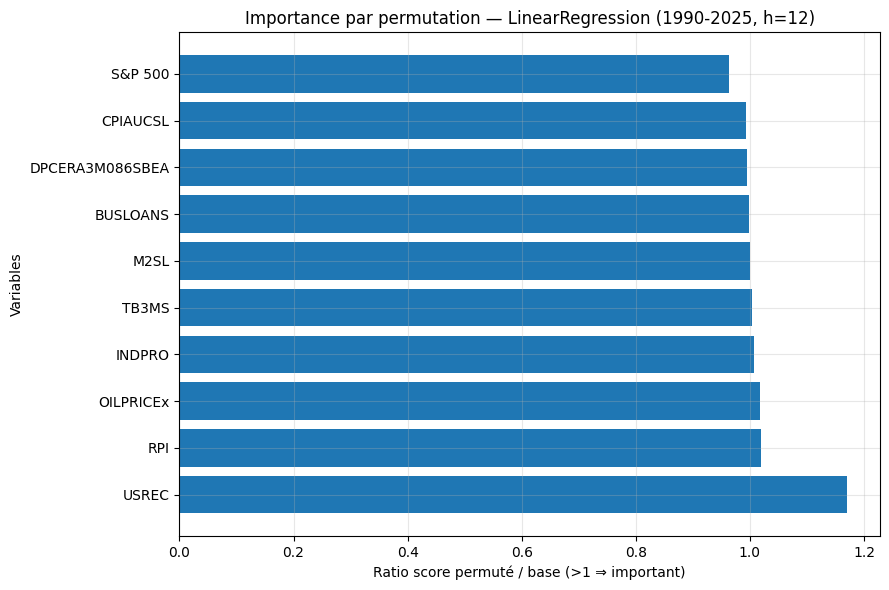

In [138]:
# ==========================================================
# PARTIE 9 — (Facultatif) Barplot des importances LR
# ==========================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.barh(imp_lin["variable"], imp_lin["perm_score_ratio_mean"])
plt.xlabel("Ratio score permuté / base (>1 ⇒ important)")
plt.ylabel("Variables")
plt.title("Importance par permutation — LinearRegression (1990-2025, h=12)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# SHAP Post-training

In [139]:
import numpy as np
import pandas as pd
import shap

# -- index mensuel (MS)
def _ensure_ms_index(idx_like):
    idx = pd.to_datetime(idx_like)
    return idx.to_period("M").to_timestamp(how="start")

# -- applique un préproc stocké (compat: lower/upper vs lower_wins/upper_wins)
def _apply_preproc_general(X: pd.DataFrame, prep: dict | None) -> pd.DataFrame:
    if prep is None:
        return X
    lower = prep.get("lower_wins", prep.get("lower", None))
    upper = prep.get("upper_wins", prep.get("upper", None))
    Xp = X
    if lower is not None and upper is not None:
        Xp = Xp.clip(lower=lower, upper=upper, axis=1)
    if prep.get("norm", False):
        mean = prep.get("mean", None)
        std  = prep.get("std",  None)
        if mean is not None and std is not None:
            Xp = (Xp - mean) / pd.Series(std).replace(0, 1)
    return Xp

# -- reconstitue la dernière fenêtre d’entraînement (jusqu’à end_time_final)
def _build_last_train_window(exp_results: dict,
                             df_all: pd.DataFrame,
                             target_col: str,
                             h: int):
    """
    Retourne (X_full, Y_full, model_final, prep_final, end_time_final)
    X_full/Y_full sont sans NaN et X_full est déjà prétraité.
    """
    if "models" not in exp_results or len(exp_results["models"]) == 0:
        raise ValueError("exp_results['models'] est vide.")
    model_final = exp_results["models"][-1]

    features = exp_results.get("features", None)
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("exp_results['features'] doit être une liste non vide.")

    preprocs = exp_results.get("preprocs", None)
    prep_final = preprocs[-1] if isinstance(preprocs, (list, tuple)) and len(preprocs) else None

    train_periods = exp_results.get("train_periods", None)
    if train_periods is None or len(train_periods) == 0:
        # fallback: on prend tout df_all
        end_time_final = df_all.index.max()
    else:
        end_time_final = pd.to_datetime(train_periods[-1])

    df = df_all.copy()
    df.index = _ensure_ms_index(df.index)
    df = df.sort_index()

    # sous-fenêtre jusqu'à la fin d'entraînement finale
    df_final = df.loc[:end_time_final].copy()
    if target_col not in df_final.columns:
        raise ValueError(f"'{target_col}' absent de df_all.")

    # X_t et y_{t+h} alignés sur t (on retire les h derniers)
    X_raw = df_final[features].iloc[:-h].copy()
    Y     = df_final[target_col].shift(-h).iloc[:-h].copy()

    # filtre lignes valides
    valid = ~(X_raw.isnull().any(axis=1) | Y.isnull())
    X_raw, Y = X_raw.loc[valid], Y.loc[valid]

    # préproc identique à celui du fit
    X_full = _apply_preproc_general(X_raw, prep_final)

    return X_full, Y, model_final, prep_final, end_time_final

# -- calcul SHAP du dernier modèle + importance moyenne absolue
def shap_importance_last_model(exp_results: dict,
                               df_all: pd.DataFrame,
                               target_col: str,
                               h: int = 12) -> pd.DataFrame:
    """
    Calcule les valeurs SHAP sur la dernière fenêtre d'entraînement
    (mêmes features, même préproc), puis renvoie un DataFrame trié
    par importance moyenne absolue (et son partage 'shap_share').
    """
    X_full, Y, model_final, prep_final, end_time_final = _build_last_train_window(
        exp_results, df_all, target_col, h
    )

    # Explainer "linear" pour rester stable avec un OLS/LR
    # (fonctionne aussi avec d'autres modèles compatibles SHAP)
    explainer = shap.Explainer(model_final, X_full, algorithm="linear")
    shap_values = explainer(X_full)

    # Récup des valeurs (selon version de shap)
    vals = getattr(shap_values, "values", None)
    if vals is None:
        vals = np.array(shap_values)

    shap_df = pd.DataFrame({
        "variable": X_full.columns,
        "shap_mean_abs": np.abs(vals).mean(axis=0),
    })
    shap_df["shap_share"] = shap_df["shap_mean_abs"] / shap_df["shap_mean_abs"].sum()
    shap_df = shap_df.sort_values("shap_mean_abs", ascending=False).reset_index(drop=True)
    return shap_df

c:\Users\Mita\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== 💡 Importance SHAP (dernier modèle) ===
       variable  shap_mean_abs  shap_share
          USREC       0.255821    0.299982
         INDPRO       0.152668    0.179022
        S&P 500       0.125215    0.146830
      OILPRICEx       0.087755    0.102903
          TB3MS       0.061062    0.071602
            RPI       0.058002    0.068015
       CPIAUCSL       0.053457    0.062685
DPCERA3M086SBEA       0.023597    0.027670
           M2SL       0.021512    0.025225
       BUSLOANS       0.013701    0.016066


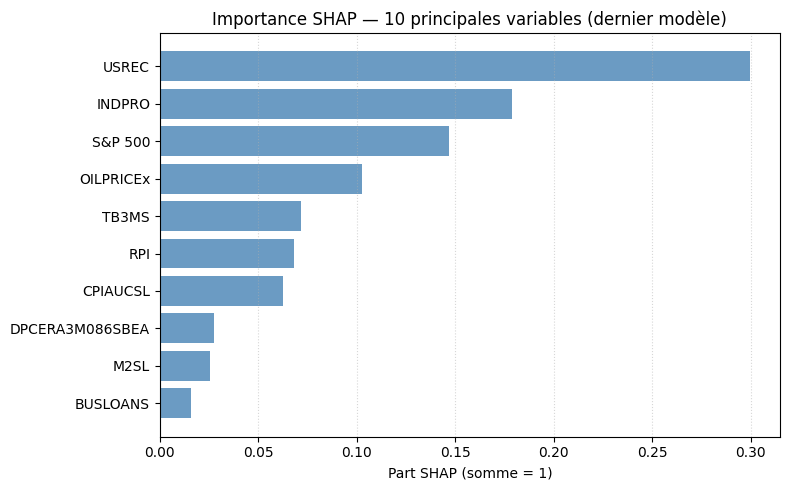

In [ ]:
# 1) Charger le bundle & reconstruire exp_results si besoin
linreg_bundle = load_any("linear_regression.pkl")

exp_lin = {
    "models":        linreg_bundle["models"],                 # modèles déjà entraînés (expanding)
    "features":      linreg_bundle["params"]["features"],     # mêmes features que pendant le fit
    "preprocs":      linreg_bundle.get("preprocs", None),     # préproc par fenêtre (dicts)
    "train_periods": linreg_bundle["train_fit_dates"],        # fins d'entraînement
    "step_months":   12,
}

# 2) Charger le DataFrame à utiliser (test ou all)
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = (
    pd.to_datetime(df_stationary_test.index).to_period("M").to_timestamp(how="start")
)
df_stationary_test = df_stationary_test.sort_index()

# 3) Importance SHAP du dernier modèle
shap_df = shap_importance_last_model(
    exp_results=exp_lin,
    df_all=df_stationary_test,  # ou df_stationary complet si tu veux la vraie dernière fenêtre de train
    target_col="UNRATE",
    h=linreg_bundle["params"].get("horizon", 12),
)

print("\n=== 💡 Importance SHAP (dernier modèle) ===")
print(shap_df.head(10).to_string(index=False))

# 4) 📊 Graphique des 10 principales variables (part SHAP)
import matplotlib.pyplot as plt

top_n = 10
df_plot = shap_df.head(top_n).iloc[::-1]  # inverser pour barh du bas vers le haut

plt.figure(figsize=(8, 5))
plt.barh(df_plot["variable"], df_plot["shap_share"], color="steelblue", alpha=0.8)
plt.xlabel("Part SHAP (somme = 1)")
plt.title("Importance SHAP — 10 principales variables (Régression linéaire)")
plt.grid(axis="x", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Test de robustesse pour la diféfrence entre régression et AR()

## Supplément

In [ ]:
def build_wide_from_long(df_long: pd.DataFrame) -> pd.DataFrame:
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    true_by_date = df.groupby("date")["true"].median().rename("true")
    wide = df.pivot_table(index="date", columns="method", values="pred", aggfunc="mean").sort_index()
    wide = wide.join(true_by_date, how="left")

    print("✅ wide prêt :", wide.shape, "| Colonnes :", wide.columns.tolist())
    return wide

In [ ]:
def make_color_map(methods: list[str]) -> dict:
    cmap = {}
    base_colors = plt.cm.get_cmap("tab10", len(methods))
    for i, m in enumerate(methods):
        cmap[m] = base_colors(i)
    cmap["true"] = "white"  # la vérité en blanc sur fond noir
    return cmap

In [ ]:
def plot_segment(
    wide: pd.DataFrame,
    start: str, end: str | None,
    title: str,
    *,
    H: int = 12,
    mode: str = "aligne",
    save: bool = True
):
    plt.style.use("dark_background")
    sub = wide.loc[start:end] if end else wide.loc[start:]

    if sub.empty:
        print(f"[!] Segment vide pour {title}")
        return

    methods = [c for c in sub.columns if c != "true"]
    colors = make_color_map(methods)

    plt.figure(figsize=(11, 4.8))
    plt.plot(sub.index, sub["true"], label="true", color=colors["true"], linewidth=2.2)

    for m in methods:
        if mode == "aligne":
            plt.plot(sub.index, sub[m], label=m, color=colors[m])
        elif mode == "decale":
            plt.plot(sub.index - pd.DateOffset(months=H), sub[m], label=m, color=colors[m])
        elif mode == "erreur":
            plt.plot(sub.index, np.abs(sub["true"] - sub[m]), label=f"|err| {m}", color=colors[m])

    plt.title(f"{title} (mode={mode}, h={H})")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save:
        fname = f"segment_{mode}_{title.replace(' ','_')}.png"
        plt.savefig(fname, dpi=150)
        print("💾 Figure enregistrée →", fname)

    plt.show()

In [ ]:
def plot_segments(df_long_filtered, segments, *, H=12, mode="aligne", save=True):
    wide = build_wide_from_long(df_long_filtered)
    for start, end, label in segments:
        plot_segment(wide, start, end, label, H=H, mode=mode, save=save)

✅ wide prêt : (428, 4) | Colonnes : ['AR(1)', 'AR(p)', 'LinearRegression', 'true']


C:\Users\Mita\AppData\Local\Temp\ipykernel_14596\676022926.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → segment_aligne_1990-1999.png


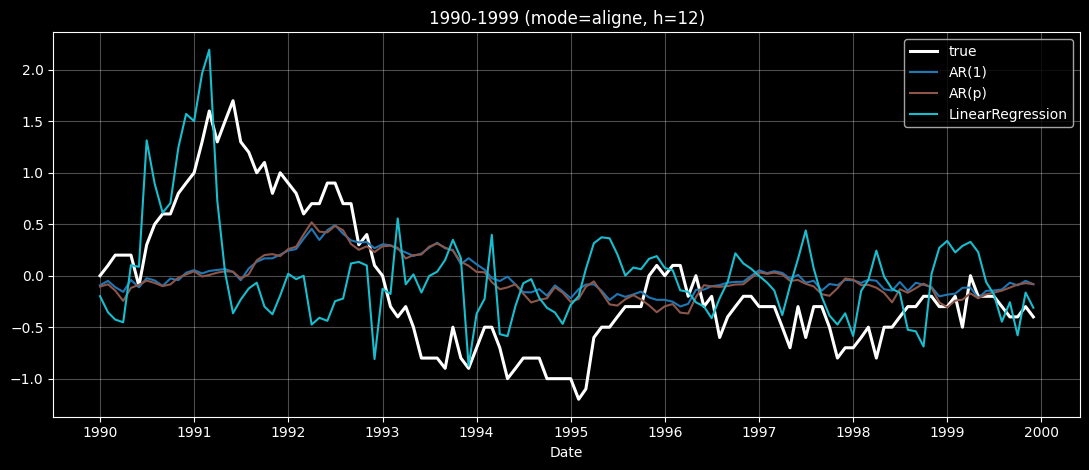

C:\Users\Mita\AppData\Local\Temp\ipykernel_14596\676022926.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → segment_aligne_2000-2008.png


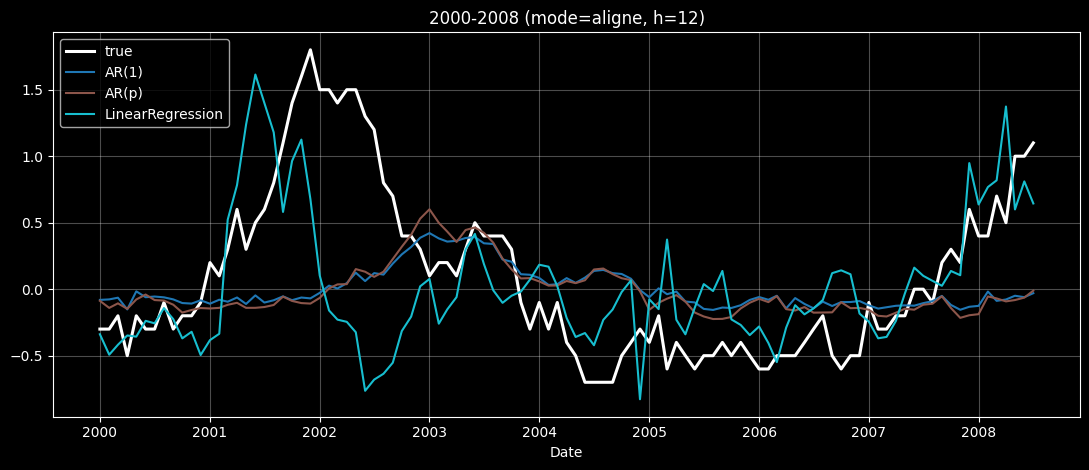

C:\Users\Mita\AppData\Local\Temp\ipykernel_14596\676022926.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → segment_aligne_2008-2019.png


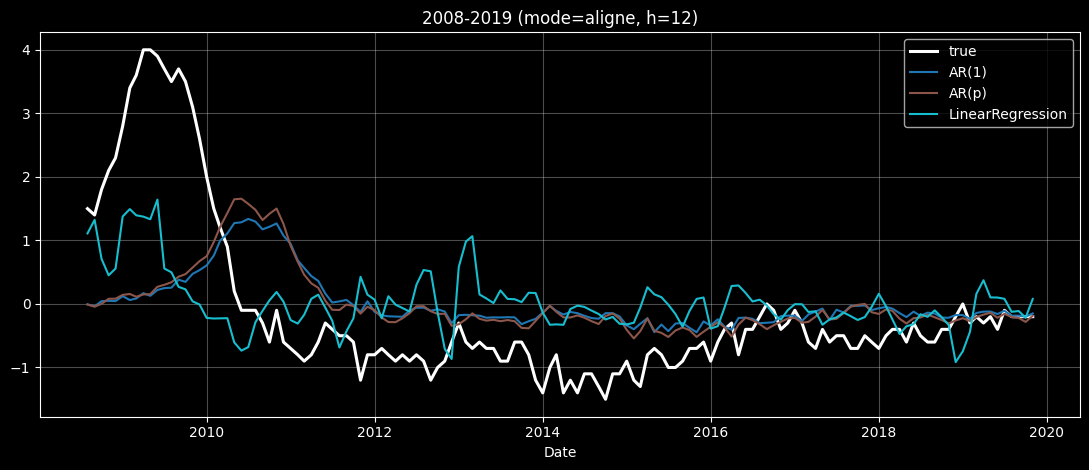

C:\Users\Mita\AppData\Local\Temp\ipykernel_14596\676022926.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → segment_aligne_2019-fin.png


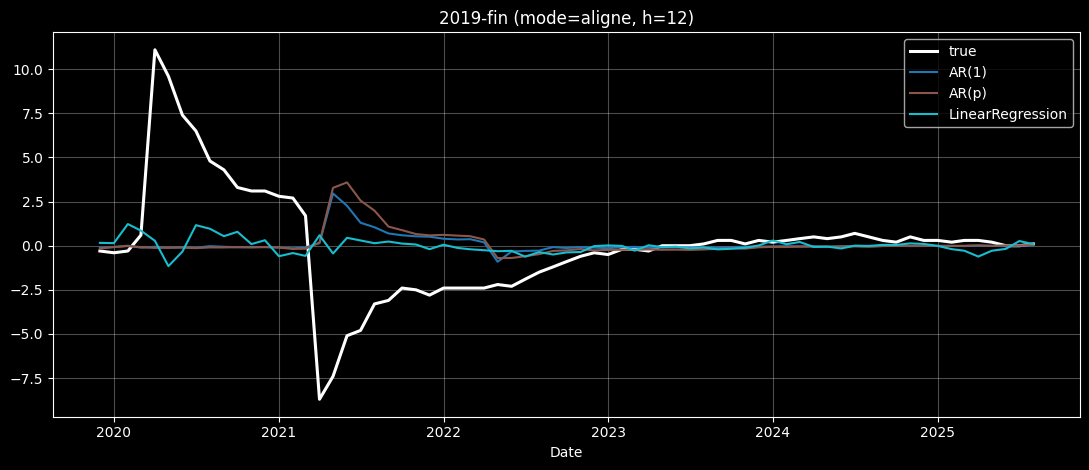

✅ wide prêt : (428, 4) | Colonnes : ['AR(1)', 'AR(p)', 'LinearRegression', 'true']


C:\Users\Mita\AppData\Local\Temp\ipykernel_14596\676022926.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → segment_aligne_zoom_2000-2008.png


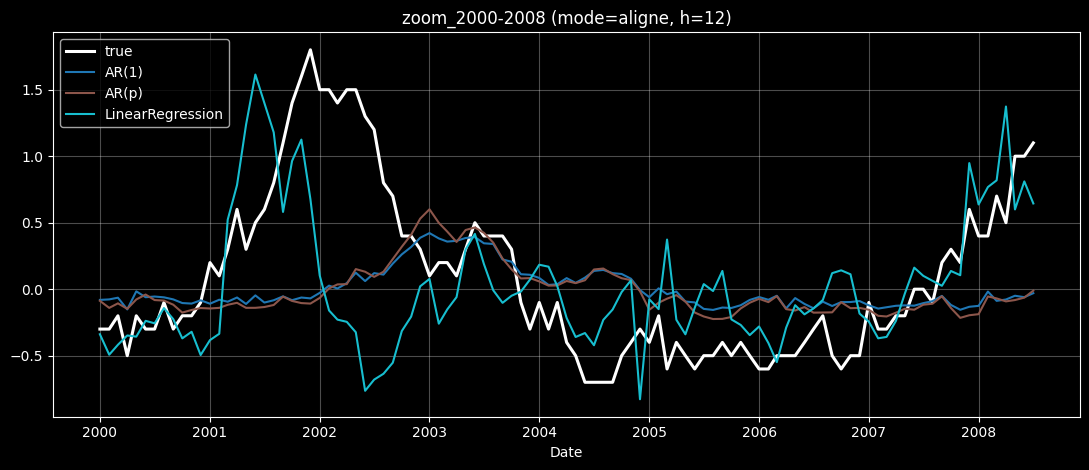

In [ ]:
# 2) Définir les fenêtres temporelles (libellés = noms de fichiers)
segments = [
    ("1990-01-01", "1999-12-31", "1990-1999"),
    ("2000-01-01", "2008-07-31", "2000-2008"),
    ("2008-08-01", "2019-11-30", "2008-2019"),
    ("2019-12-01", None,         "2019-fin"),
]

# 3) Tracer toutes les fenêtres (mode aligné)
plot_segments(df_pred_long, segments, H=12, mode="aligne", save=True)

# 👉 Alternatives :
# plot_segments(df_1990, segments, H=12, mode="decale", save=True)
# plot_segments(df_1990, segments, H=12, mode="erreur", save=True)

# 4) (Optionnel) Tracer un seul segment rapidement
wide = build_wide_from_long(df_pred_long)
plot_segment(wide, "2000-01-01", "2008-07-31", "zoom_2000-2008", H=12, mode="aligne", save=True)

# Evaluation des apports apportes des variables